In [2]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications import VGG19, ResNet50, InceptionV3

sys.version

'3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]'

## Load data

In [3]:
# base_path = 'Dataset/flowers/'
base_path = 'flowers/'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#### Load file names

In [4]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)


In [5]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


#### Load images

In [6]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [7]:
print('number of images for each category:', [len(f) for f in images])


number of images for each category: [769, 1052, 784, 734, 984]


#### Calculate the minimal shape for all images

In [8]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))


125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip
[(209, 320, 3), (335, 500, 3), (335, 500, 3), (333, 500, 3), (214, 320, 3), (335, 500, 3), (333, 500, 3), (231, 320, 3), (333, 500, 3), (332, 500, 3), (375, 500, 3), (375, 500, 3), (239, 320, 3), (234, 320, 3), (229, 320, 3), (180, 240, 3), (233, 320, 3), (220, 320, 3), (232, 320, 3), (239, 320, 3), (240, 170, 3), (333, 500, 3), (313, 500, 3), (240, 320, 3), (318, 500, 3), (333, 500, 3), (272, 320, 3), (248, 500, 3), (276, 320, 3), (240, 320, 3), (240, 320, 3), (240, 320, 3), (333, 500, 3), (240, 320, 3), (334, 500, 3), (333, 500, 3), (333, 500, 3), (215, 500, 3), (258, 320, 3), (240, 240, 3), (286, 320, 3), (246, 320, 3), (240, 320, 3), (240, 320, 3), (240, 320, 3), (240, 210, 3), (213, 320, 3), (240, 320, 3), (240, 320, 3), (240, 159, 3), (332, 500, 3), (240, 320, 3), (241, 320, 3), (240, 320, 3), (332, 500

#### Create a function to convert cv2 BGR format to RGB for showing

In [9]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#### Show sample images for all flowers

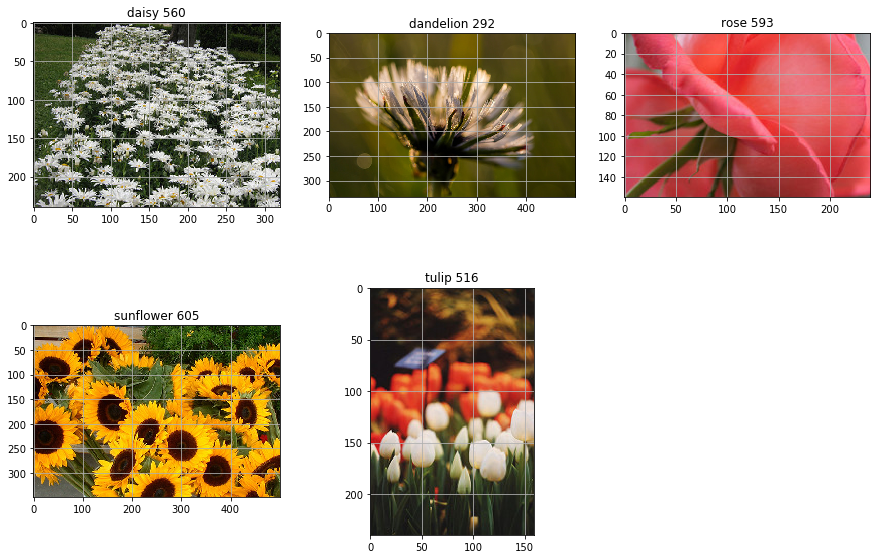

In [10]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

#### Resize all the images to 256x256

(240, 240, 3)
(256, 256, 3)


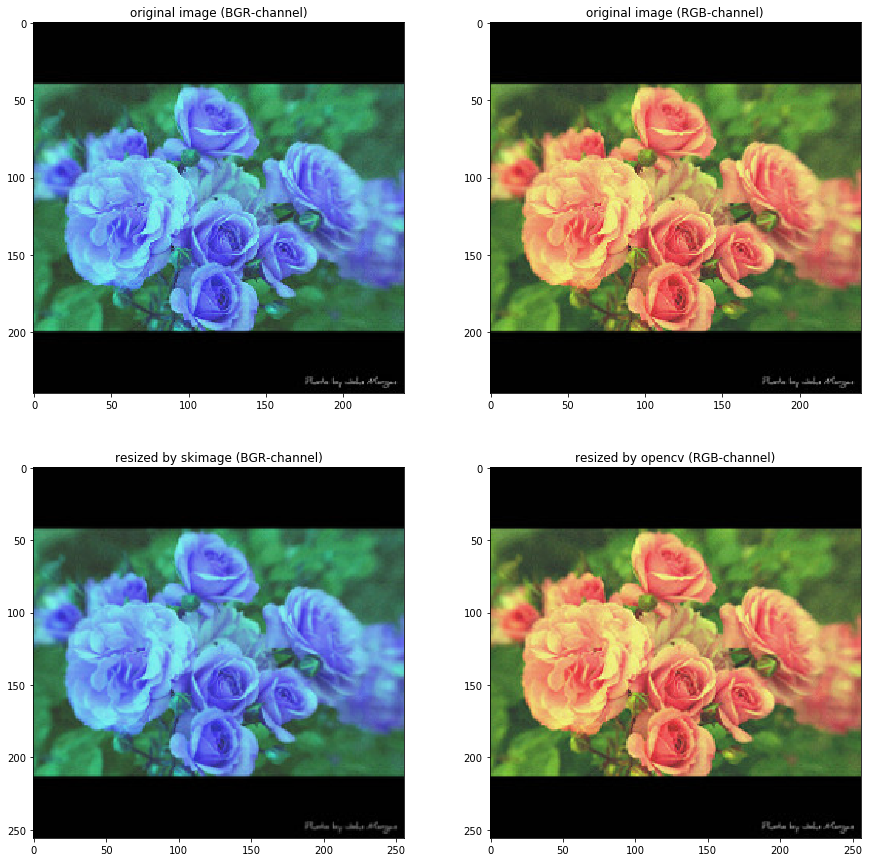

In [11]:
img_width, img_height = 256, 256

img = images[2][600]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [12]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

#### Split dataset to 80% of training and 20% of validation 

In [13]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

#### Create labels

In [14]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[615, 841, 627, 587, 787]
sum of train images: 3457
[154, 211, 157, 147, 197]
sum of val_images: 866


#### Convert image data to numpy array
Convert and pre-processing

convert class labels to binary class labels

In [15]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [16]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3457, 256, 256, 3)
train labels: (3457,)

After converting
train data: (3457, 256, 256, 3)
train labels: (3457, 5)


#### Shuffle the dataset (set a seed and randomize both the data and the labels)

In [17]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [18]:
train_data = train_data[:]
train_labels = train_labels[:]
val_data = val_data[:]
val_labels = val_labels[:]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3457, 256, 256, 3)
shape of train labels: (3457, 5)
shape of val data: (866, 256, 256, 3)
shape of val labels: (866, 5)


## Build the model

In [19]:
WEIGHTS_PATH_NO_TOP = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [20]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [21]:
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)
    
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return final_model

In [22]:
def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights=WEIGHTS_PATH_NO_TOP))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [23]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0

In [24]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [25]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)             

## Prepare input data

In [26]:
# Parameters
batch_size = 32
epochs1 = 50
epochs2 = 10
epochs3 = 30

#### Create generator

In [27]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

## Train the model

#### Fit the model with generator

In [ ]:
start = time.time()

model_scratch_info = model_scratch.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs1) )

Epoch 1/50


In [ ]:
start = time.time()

model_VGG19_info = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs2, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator,
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs2) )

In [ ]:
start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs3, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )

In [ ]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [ ]:
# plt.figure(figsize=(15,15))
# # indexs = [10, 20, 30, 40, 50, 60, ]
# for i in range(9):
#   idx = np.random.randint(860)
#   plt.subplot(3,3,i+1)
#   plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
#   category_idx = return_name(val_labels[idx])
#   plt.title(categories[category_idx])
#   plt.grid('off')
# plt.show()

## Predict and evaluate the model

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

In [ ]:
plot_model_history('model_scratch', model_scratch_info.history, epochs1)
plot_model_history('model_VGG19', model_VGG19_info.history, epochs2)
plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs3)

#### Predict one image

In [ ]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('drive/My Drive/AI/Dataset/test_images/rose1.jpg')
pred, probability = predict_one_image(test_img, model_ResNet50)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
print("Model trained from ResNet-50")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_ResNet50)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
my_model.save('drive/My Drive/AI/My_Model/flowers_classification_pretrained_by_resnet50_acc_92.h5')